In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [2]:
from tqdm import tqdm
import requests
import os
import zipfile

def download_file(src_url, dst_fn):
    
    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return
    
    print('Downloading %s' % dst_fn)
    
    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    with open(dst_fn, 'wb') as f:
        with tqdm(total=total_size//block_size, unit='kB', 
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong") 

# Get file names
matlab_dir = 'matlab'
digits_fn =  os.path.join(matlab_dir,'emnist-digits.mat')
letters_fn = os.path.join(matlab_dir,'emnist-letters.mat')

# Check if files exists
if os.path.exists(matlab_dir):
    if os.path.exists(digits_fn) and os.path.exists(letters_fn):
        print('Files already downloaded')
        files_exists = True
else:
    files_exists = False
    
if not files_exists:
    # First download the zip file if needed
    src_url = "http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip"
    dst_fn = 'matlab.zip'
    download_file(src_url, dst_fn)
    
    # Then, unzip the file
    print('Unzipping %s...' % dst_fn)
    zip_ref = zipfile.ZipFile(dst_fn, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Unzip completed')

Files already downloaded


In [3]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):

    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

In [4]:
Xtr_dig, Xts_dig, ytr_dig, yts_dig =load_emnist(digits_fn)

240000 training samples, 40000 test samples loaded


In [5]:
Xtr_let, Xts_let, ytr_let, yts_let =load_emnist(letters_fn)

124800 training samples, 20800 test samples loaded


In [6]:
def plt_digit(x,y=None):
    # Constants
    nrow = 28
    ncol = 28
    # Reshape the flat array into a 28x28 2D array
    xsq = x.reshape((nrow,ncol))
    # Display the image transposed
    plt.imshow(xsq.T,  cmap='Greys_r')
    # Remove the x and y ticks (numbers) for a cleaner image display
    plt.xticks([])
    plt.yticks([])    
    if y is not None:
        plt.title(f'{y}')   

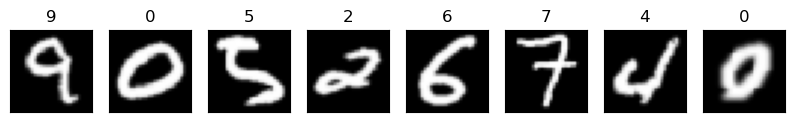

In [7]:
nplt=8
nsamp=Xtr_dig.shape[0]
# Random permutation of indices
Iperm=np.random.permutation(nsamp)
# Set the figure size for the plot
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind=Iperm[i]
    # Create subplot for each image
    plt.subplot(1,nplt,i+1)
    plt_digit(Xtr_dig[ind,:],ytr_dig[ind])
plt.show()

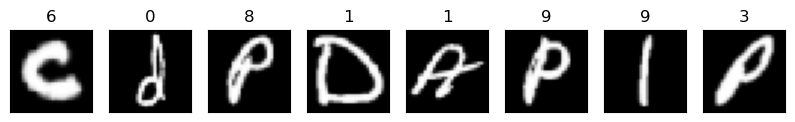

In [8]:
nplt=8
nsamp=Xtr_let.shape[0]
Iperm=np.random.permutation(nsamp)

plt.figure(figsize=(10,20))
for i in range(nplt):
    # Select the index for the ith plot from the permuted list
    ind=Iperm[i]
    # Prepare a subplot in a 1x'nplt' grid at the ith position
    plt.subplot(1,nplt,i+1)
    # Plot the ith letter and label it with the corresponding digit label
    plt_digit(Xtr_let[ind,:],ytr_dig[ind])
plt.show()

In [9]:
remove_list = np.array([9,12,15]) # Labels to be removed
# Select indices of training labels that are not in the remove list
I=np.all(ytr_let[:,None]!=remove_list[None,:],axis=1)
Xtr_let_rem=Xtr_let[I,:]
ytr_let_rem=ytr_let[I]
# Select indices of test labels that are not in the remove list
I=np.all(yts_let[:,None]!=remove_list[None,:],axis=1)
Xts_let_rem=Xts_let[I,:]
yts_let_rem=yts_let[I]

In [10]:
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

def rand_sel(X,y,n):
    n0=X.shape[0]
    # Randomly permute indices up to number of samples
    I=np.random.permutation(n0)
    # Select n samples from X
    X1=X[I[:n],:]
    # Select corresponding n labels from y
    y1=y[I[:n]]
    return X1,y1
# Randomly select samples for digits training set
Xtr1_dig, ytr1_dig=rand_sel(Xtr_dig,ytr_dig,ntr_dig)
# Same for test set
Xts1_dig, yts1_dig=rand_sel(Xts_dig,yts_dig,nts_dig)
# For letters training set
Xtr1_let, ytr1_let=rand_sel(Xtr_let_rem,ytr_let_rem,ntr_let)
# For letters test set
Xts1_let, yts1_let=rand_sel(Xts_let_rem,yts_let_rem,nts_let)

In [11]:
# TODO: Create combined letter and digit training and test data # Xtr, ytr = ..
# Xts, yts = ...
# Combine digit and letter training data vertically
Xtr=np.vstack((Xtr1_dig,Xtr1_let)) 
# Combine labels and add '10' for letter labels
ytr=np.hstack((ytr1_dig,10*np.ones(ntr_let,dtype='int')))
# Combine digit and letter test data vertically
Xts=np.vstack((Xts1_dig,Xts1_let))
# Combine labels and add '10' for letter labels
yts=np.hstack((yts1_dig,10*np.ones(nts_let,dtype='int')))

In [12]:
Xtr1=2*Xtr/255.0-1
Xts1=2*Xts/255.0-1

In [13]:
from sklearn import svm
# TODO:  Create a classifier: a support vector classifier
# svc = ...
svc=svm.SVC(probability=False,kernel="rbf",C=2.8,gamma=.0073,verbose=10)

In [14]:
# Fit the classifier on the training data
svc.fit(Xtr1, ytr)

[LibSVM]*
optimization finished, #iter = 178
obj = -30.915822, rho = -0.199471
nSV = 71, nBSV = 3
*
optimization finished, #iter = 424
obj = -87.030771, rho = 0.729537
nSV = 162, nBSV = 12
*
optimization finished, #iter = 355
obj = -62.272583, rho = 0.015948
nSV = 144, nBSV = 7
*
optimization finished, #iter = 335
obj = -55.431391, rho = 0.431977
nSV = 126, nBSV = 7
*
optimization finished, #iter = 487
obj = -101.948025, rho = 0.757813
nSV = 182, nBSV = 11
*
optimization finished, #iter = 455
obj = -87.921965, rho = -0.018085
nSV = 163, nBSV = 11
*
optimization finished, #iter = 253
obj = -40.702977, rho = 0.201907
nSV = 104, nBSV = 1
*
optimization finished, #iter = 337
obj = -69.424894, rho = 0.369637
nSV = 138, nBSV = 7
*
optimization finished, #iter = 245
obj = -49.681735, rho = 0.125717
nSV = 104, nBSV = 7
*
optimization finished, #iter = 815
obj = -331.575008, rho = 2.711464
nSV = 342, nBSV = 104
*
optimization finished, #iter = 302
obj = -77.752995, rho = 0.977271
nSV = 116, nBS

SVC(C=2.8, gamma=0.0073, verbose=10)

In [15]:
yhat = svc.predict(Xts1)
acc = np.mean(yhat == yts) 
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.894667


[[0.947 0.002 0.    0.004 0.002 0.    0.002 0.    0.004 0.    0.019]
 [0.    0.961 0.002 0.004 0.    0.    0.    0.    0.    0.    0.017]
 [0.002 0.004 0.932 0.008 0.    0.    0.    0.004 0.006 0.    0.02 ]
 [0.008 0.004 0.009 0.92  0.    0.004 0.    0.007 0.013 0.006 0.013]
 [0.    0.    0.    0.    0.887 0.    0.002 0.    0.    0.017 0.047]
 [0.006 0.    0.    0.023 0.002 0.888 0.004 0.    0.    0.    0.041]
 [0.004 0.002 0.    0.002 0.    0.004 0.945 0.    0.    0.    0.021]
 [0.    0.004 0.    0.    0.008 0.    0.    0.957 0.002 0.017 0.008]
 [0.002 0.008 0.    0.023 0.002 0.004 0.    0.002 0.883 0.015 0.034]
 [0.    0.004 0.    0.012 0.016 0.002 0.    0.03  0.004 0.896 0.014]
 [0.043 0.025 0.07  0.035 0.073 0.075 0.041 0.013 0.042 0.07  0.759]]


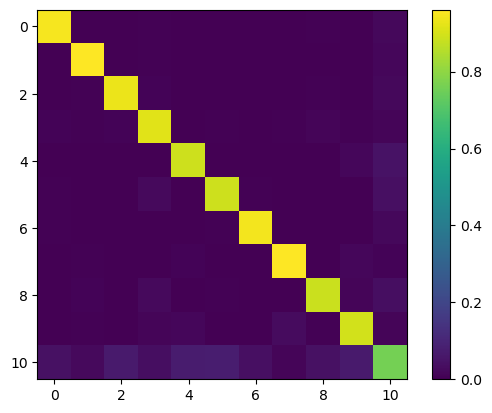

In [16]:
from sklearn.metrics import confusion_matrix 
# Compute confusion matrix for true labels yts and predicted labels yhat
C = confusion_matrix(yts,yhat)

# Calculate the sum of each row in the confusion matrix

sum_C = np.sum(C,1)
# Normalize the confusion matrix by the sum of each row to get the proportions
C = C / sum_C[None,:]
# Print the normalized confusion matrix with 3 decimal places precision
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [17]:
# Predict the labels for the digit test set
yhat = svc.predict(Xts1_dig)
# Calculate accuracy
acc = np.mean(yhat == yts1_dig) 
print('Accuaracy = {0:f}'.format(acc))
# Predict the labels for the letter test set
yhat = svc.predict(Xts1_let)
# Calculate accuracy
acc = np.mean(yhat == yts1_let)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.000000
Accuaracy = 0.033000


In [18]:
# Define lists of parameters for grid search
C_test = [0.1, 1, 10]
gam_test = [0.001, 0.01, 0.1]

# Determine number of values to test for each parameter
nC = len(C_test)
ngam = len(gam_test)

# Iterate over all combinations of parameters C and gamma to find the best model
for C_value in C_test:
    for gamma_value in gam_test:
        # Initialize SVC with current C and gamma values
        svc = svm.SVC(probability=False, kernel="rbf", C=C_value, gamma=gamma_value, verbose=10)
        svc.fit(Xtr1, ytr)
        yhat = svc.predict(Xts1)
        # Calculate the accuracy of predictions
        acc = np.mean(yhat == yts)
        # Print the accuracy for the current C and gamma combination
        print(f'Accuracy with C={C_value} and gamma={gamma_value}: {acc:f}')

[LibSVM]*
optimization finished, #iter = 240
obj = -27.196780, rho = -0.360680
nSV = 448, nBSV = 440
*
optimization finished, #iter = 369
obj = -50.870532, rho = 0.233194
nSV = 731, nBSV = 723
*
optimization finished, #iter = 355
obj = -47.211385, rho = 0.056155
nSV = 697, nBSV = 692
*
optimization finished, #iter = 322
obj = -39.757966, rho = 0.112654
nSV = 616, nBSV = 600
*
optimization finished, #iter = 413
obj = -56.091219, rho = 0.320063
nSV = 795, nBSV = 788
*
optimization finished, #iter = 394
obj = -53.878447, rho = 0.000017
nSV = 768, nBSV = 764
*
optimization finished, #iter = 312
obj = -39.003314, rho = 0.019626
nSV = 604, nBSV = 591
*
optimization finished, #iter = 357
obj = -46.072273, rho = 0.167771
nSV = 687, nBSV = 674
*
optimization finished, #iter = 293
obj = -36.991131, rho = -0.044846
nSV = 574, nBSV = 565
*
optimization finished, #iter = 490
obj = -72.865915, rho = 0.884210
nSV = 934, nBSV = 925
*
optimization finished, #iter = 345
obj = -46.156435, rho = 0.736669


[[0.284 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.353]
 [0.    0.909 0.    0.    0.    0.    0.    0.    0.    0.    0.047]
 [0.    0.    0.013 0.    0.    0.    0.    0.    0.    0.    0.463]
 [0.    0.    0.    0.21  0.    0.    0.    0.    0.    0.    0.384]
 [0.    0.    0.    0.    0.188 0.    0.    0.    0.    0.004 0.401]
 [0.    0.    0.    0.    0.    0.087 0.    0.    0.    0.    0.473]
 [0.    0.    0.    0.    0.    0.    0.339 0.    0.    0.    0.322]
 [0.    0.    0.    0.    0.    0.    0.    0.595 0.    0.004 0.217]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.147 0.    0.446]
 [0.    0.    0.    0.    0.    0.    0.    0.004 0.002 0.427 0.268]
 [0.    0.    0.    0.    0.004 0.    0.    0.    0.    0.015 0.991]]


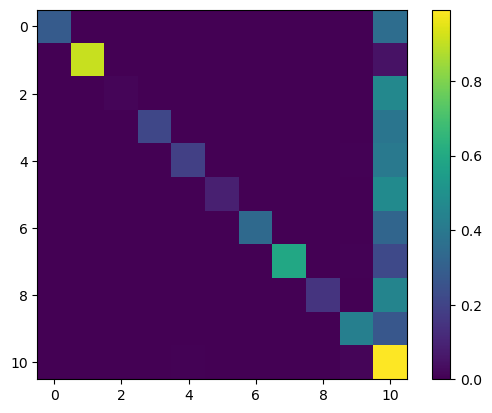

In [19]:
# TODO: Print the accuracy matrix
from sklearn.metrics import confusion_matrix 
# Compute the confusion matrix for true labels yts and predicted labels yhat
C = confusion_matrix(yts,yhat)

# Normalize the confusion matrix by dividing by the sum of each row
sum_C = np.sum(C,1)
C = C / sum_C[None,:]

# Print the confusion matrix(precision 3 decimal)
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [20]:
svc=svm.SVC(probability=False,kernel="rbf",C=10,gamma=0.01,verbose=10) 
# Fit model to training data (Xtr1, ytr)
svc.fit(Xtr1,ytr)
# Predict the labels on Xts1
yhat = svc.predict(Xts1)
# Calculate accuracy
acc = np.mean(yhat == yts)
print(' The Best Accuaracy is {0:f}'.format(acc))
print('C=10')
print('gamma=0.01')

[LibSVM]*
optimization finished, #iter = 179
obj = -25.895965, rho = -0.214700
nSV = 84, nBSV = 0
*
optimization finished, #iter = 446
obj = -71.257128, rho = 0.576863
nSV = 177, nBSV = 0
*
optimization finished, #iter = 424
obj = -53.612023, rho = 0.011450
nSV = 171, nBSV = 0
*
optimization finished, #iter = 335
obj = -46.174273, rho = 0.356126
nSV = 150, nBSV = 0
*
optimization finished, #iter = 559
obj = -82.757463, rho = 0.582217
nSV = 212, nBSV = 0
*
optimization finished, #iter = 484
obj = -74.062256, rho = -0.022901
nSV = 194, nBSV = 0
*
optimization finished, #iter = 282
obj = -35.099033, rho = 0.149120
nSV = 121, nBSV = 0
*
optimization finished, #iter = 388
obj = -58.324246, rho = 0.315461
nSV = 167, nBSV = 0
*
optimization finished, #iter = 278
obj = -41.632422, rho = 0.122960
nSV = 125, nBSV = 0
*.*
optimization finished, #iter = 1152
obj = -271.851468, rho = 2.220264
nSV = 392, nBSV = 0
*
optimization finished, #iter = 346
obj = -65.512242, rho = 0.717215
nSV = 133, nBSV =